# Cancer Image Identification

### Description

This data is PatchCamylon benchmark dataset which is implified version of Original dataset that exclude duplicate images.


### Modeling

I've used pre-train models of VGG16 + Custom model.
Please refer details below

### Imports Library

In [1]:
import numpy as np
import pandas as pd
import os


base_dir = '../input/histopathologic-cancer-detection/'
print(os.listdir(base_dir))

['sample_submission.csv', 'train_labels.csv', 'test', 'train']


In [2]:
labels = pd.read_csv(base_dir + "train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
train_path = base_dir + "train/"
test_path = base_dir + "test/"
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

### EDA : Size of Train & Test

In [4]:
print("Train size: ", len(train_files))
print("Test size: ", len(test_files))

Train size:  220025
Test size:  57458


### EDA : Counts of Response variable

In [5]:
labels.label.value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
sns.set()
from PIL import Image


positive_images = np.random.choice(labels[labels.label==1].id, size=50, replace=False)
negative_images = np.random.choice(labels[labels.label==0].id, size=50, replace=False)

### EDA : Image of Positive

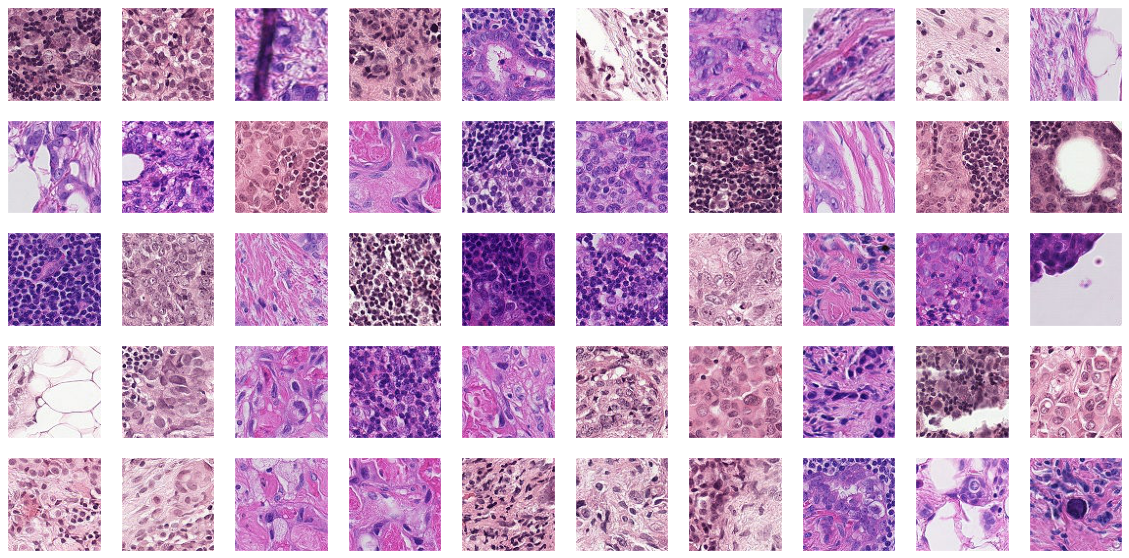

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = positive_images[m + n*10]
        image = Image.open(train_path + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

### EDA : Image of Negative

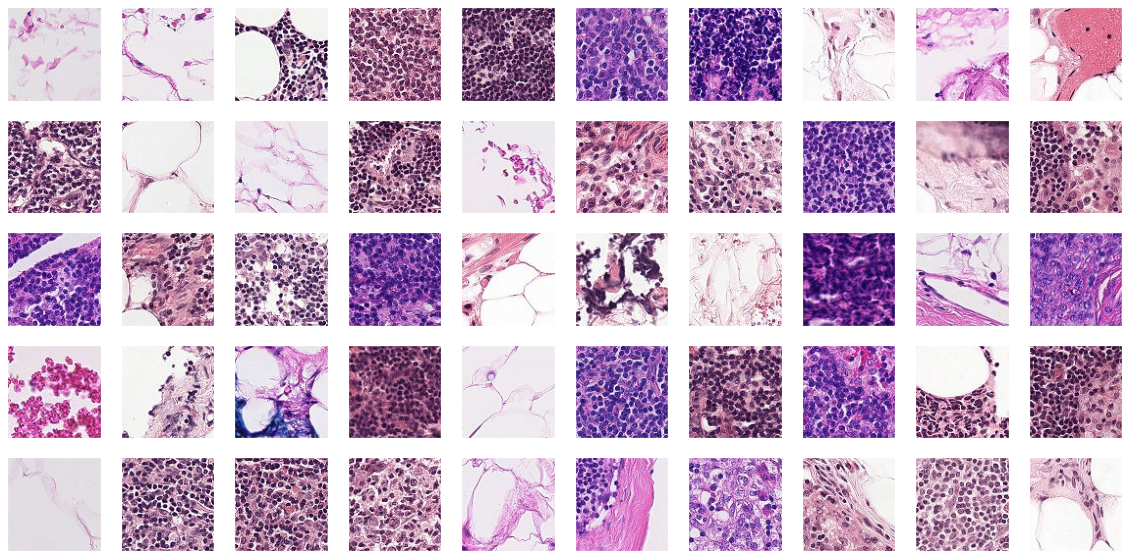

In [8]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = negative_images[m + n*10]
        image = Image.open(train_path + img_id + ".tif")
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16

from shutil import copyfile, move
from tqdm import tqdm
import h5py
import random

In [10]:
dataset_df = pd.read_csv(base_dir + "train_labels.csv")
dataset_df["filename"] = [item.id+".tif" for idx, item in dataset_df.iterrows()]
dataset_df["groundtruth"] = ["cancerous" if item.label==1 else "healthy" for idx, item in dataset_df.iterrows()]
dataset_df.head()


,id,label,filename,groundtruth
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,healthy
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,cancerous
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,healthy
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,healthy
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,healthy


In [11]:
training_sample_percentage = 0.8
training_sample_size = int(len(dataset_df)*training_sample_percentage)
validation_sample_size = len(dataset_df)-training_sample_size

training_df = dataset_df.sample(n=training_sample_size)
validation_df = dataset_df[~dataset_df.index.isin(training_df.index)]

In [12]:
training_batch_size = 64
validation_batch_size = 64
target_size = (96,96)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = training_df,
    x_col='filename',
    y_col='groundtruth',
    directory= train_path,
    target_size=target_size,
    batch_size=training_batch_size,
    shuffle=True,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = validation_df,
    x_col='filename',
    y_col='groundtruth',
    directory=train_path,
    target_size=target_size,
    shuffle=False,
    batch_size=validation_batch_size,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Use Pretrained Model VGG16


I've choose VGG16 model for pre-trained model,
and add custom layers like :

2D Average Pooling  
Dense Layer with 256  
Batch Normalization  
Relu Activation  
Drop out layer  
output layer  

Commonly, Max Pooling is the most used layer, but Average pooling works better in this project.
I've concenred about over-fiiting, so I include batch normalization and drop-out layer to avoid this issue.



In [13]:
input_shape = (96, 96, 3)
pretrained_layers = VGG16(weights='imagenet',include_top = False, input_shape=input_shape)
pretrained_layers.summary()

2022-06-15 13:47:29.938880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:47:30.052884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:47:30.053664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 13:47:30.054867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [14]:
for layer in pretrained_layers.layers[:-8]:
    layer.trainable = False

for layer in pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f22f5b64890> False
<keras.layers.convolutional.Conv2D object at 0x7f22f363ae90> False
<keras.layers.convolutional.Conv2D object at 0x7f22f588f610> False
<keras.layers.pooling.MaxPooling2D object at 0x7f22f02bc750> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02c4d90> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02cc590> False
<keras.layers.pooling.MaxPooling2D object at 0x7f22f02d0890> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02d5450> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02dad50> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02e6450> False
<keras.layers.pooling.MaxPooling2D object at 0x7f22f02dd490> False
<keras.layers.convolutional.Conv2D object at 0x7f22f02ead10> True
<keras.layers.convolutional.Conv2D object at 0x7f22f0273690> True
<keras.layers.convolutional.Conv2D object at 0x7f22f0278a10> True
<keras.layers.pooling.MaxPooling2D object at 0x7f22f02ea650> Tr

In [15]:
dropout_dense_layer = 0.6

model = Sequential()
model.add(pretrained_layers)
    
model.add(GlobalAveragePooling2D())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [17]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [18]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5),
             EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

train_step_size = train_generator.n // train_generator.batch_size
validation_step_size = validation_generator.n // validation_generator.batch_size

In [19]:
epochs = 5
history = model.fit_generator(train_generator,
          steps_per_epoch = train_step_size,
          validation_data= validation_generator,
          validation_steps = validation_step_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-15 13:47:35.423543: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-06-15 13:47:37.825790: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2750/2750 [==============================] - 2277s 825ms/step - loss: 0.3255 - accuracy: 0.8635 - val_loss: 0.2949 - val_accuracy: 0.8825
Epoch 2/5
2750/2750 [==============================] - 887s 323ms/step - loss: 0.2588 - accuracy: 0.8962 - val_loss: 0.3714 - val_accuracy: 0.8624

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/5
2750/2750 [==============================] - 774s 282ms/step - loss: 0.2274 - accuracy: 0.9114 - val_loss: 0.2963 - val_accuracy: 0.8915

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/5
2750/2750 [==============================] - 747s 271ms/step - loss: 0.2072 - accuracy: 0.9203 - val_loss: 0.2085 - val_accuracy: 0.9178
Epoch 5/5
2750/2750 [==============================] - 723s 263ms/step - loss: 0.1995 - accuracy: 0.9231 - val_loss: 0.2192 - val_accuracy: 0.9129

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


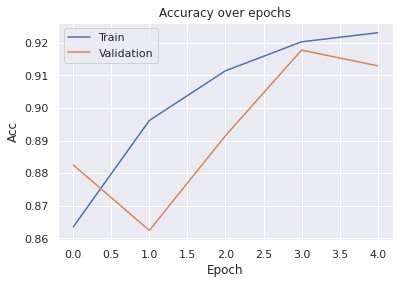

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over epochs')
plt.ylabel('Acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

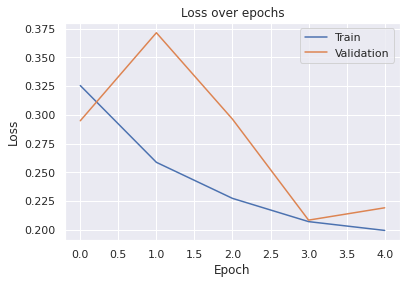

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [22]:
model.load_weights("best_model.h5")

In [23]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory="../input/dataset/test/",
    target_size=target_size,
    batch_size=1,
    shuffle=False
)


Found 126 images belonging to 2 classes.


In [24]:
pred=model.predict_generator(test_generator,verbose=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


126/126 [==============================] - 21s 166ms/step
